In [123]:
import sys

moduleLoc = "/Users/Lykke-AndersenLab/PycharmProjects/AnoThER-Seq"
if moduleLoc in sys.path: 
    print('woo')
else:
    sys.path.append(moduleLoc)
import matplotlib.pyplot as plt
import tools, analysis
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats

# Enable inline plotting
%matplotlib inline

woo


In [2]:
#read tail files into a pd dataframe
import imp
imp.reload(tools)
folderLoc = "/Users/Lykke-AndersenLab/Dropbox/NoctData/"
controlName = "siLuc.tails"
KDname = "siNoct.tails"
WTname = "NoctWT.tails"
EAname = "NoctEA.tails"

# Function to read in .tail format file and return a dataframe
control = tools.pdTailMaker(folderLoc+controlName)
print('Control In!')
knockdown = tools.pdTailMaker(folderLoc+KDname)
print('Knockdown In!')
WTaddback = tools.pdTailMaker(folderLoc+WTname)
print('WT In!')
EAaddback = tools.pdTailMaker(folderLoc+EAname)
print('EA In!')

Control In!
Knockdown In!
WT In!
EA In!


In [131]:
# Filter and combine tail data
minTail = -10
maxTail = 10

def filtTails(df, source, minTail, maxTail):
    newDf = df[(df['3Loc']+df['TailLength'])>=minTail]
    newDf = newDf[(newDf['3Loc']+newDf['TailLength'])<=maxTail]
    newDf['Source'] = source
    newDf['TotalTail'] = newDf['3Loc'] + newDf['TailLength']
    return newDf

f_control = filtTails(control, 'siLuc',minTail,maxTail)
f_knockdown = filtTails(knockdown, 'siNoct',minTail,maxTail)
f_WT = filtTails(WTaddback,'WT Addback',minTail,maxTail)
f_EA = filtTails(EAaddback,'EA Addback',minTail,maxTail)


# Combined experimental data
combo = pd.concat([f_control,
                   f_knockdown,
                   f_WT,
                   f_EA],
                  ignore_index=True)

print ("CONTROL\nInitial: {}\nFiltered: {}\n".format(len(control),len(filtControl)))
print ("KNOCKDOWN\nInitial: {}\nFiltered: {}\n".format(len(knockdown),len(filtKD)))
print ("WT\nInitial: {}\nFiltered: {}\n".format(len(WTaddback),len(filtWT)))
print ("EA\nInitial: {}\nFiltered: {}\n".format(len(EAaddback),len(filtEA)))

combo.set_index('Gene', inplace=True)
#combo.to_csv('combo.csv')

combo.head()

CONTROL
Initial: 3903782
Filtered: 1351776

KNOCKDOWN
Initial: 4621080
Filtered: 1324006

WT
Initial: 2411894
Filtered: 759185

EA
Initial: 2579469
Filtered: 779416



,3Loc,TailLength,TailSeq,Type,Source,TotalTail
Gene,,,,,,
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0


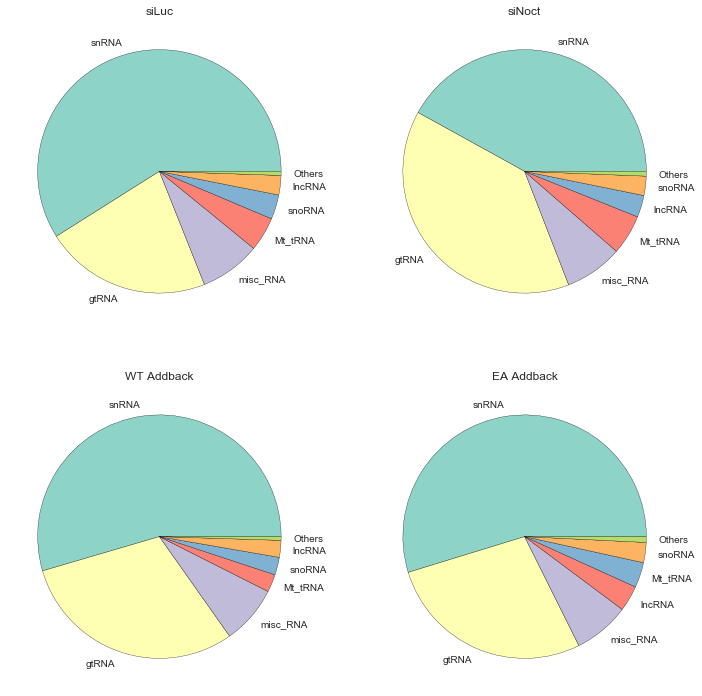

In [250]:
#Plot distribution of mapped reads
f, axarr = plt.subplots(2,2, figsize=(12,12), )
axarr[0,0].set_title("siLuc")
axarr[0,1].set_title("siNoct")
axarr[1,0].set_title("WT Addback")
axarr[1,1].set_title("EA Addback")


def pieMaker (df, column, otheredNum, axis):
    x = list(df[column].value_counts()[:-otheredNum].values)
    others = df[column].value_counts()[-otheredNum:].values
    others = sum(others)
    labels = df[column].value_counts()[:-otheredNum].index.tolist()
    labels += ["Others"]
    colors = sns.color_palette("Set3", 10)
    x +=[others]
    plt.subplot(axis)
    axis = plt.pie(x,labels=labels, colors=colors)
pieMaker(f_control,'Type',4, axarr[0,0])
pieMaker(f_knockdown,'Type',4, axarr[0,1])
pieMaker(f_WT,'Type',4,axarr[1,0])
pieMaker(f_EA,'Type',5,axarr[1,1])

#f_control['Type'].value_counts().plot(kind='pie',ax=axarr[0,0])
#f_knockdown['Type'].value_counts().plot(kind='pie',ax=axarr[0,1])
#f_WT['Type'].value_counts().plot(kind='pie', ax=axarr[1,0])
#f_EA['Type'].value_counts().plot(kind='pie',ax=axarr[1,1])

In [ ]:
# Create TPM Table and Save to CSV

def TPMmaker(df, source, totalReads):
    df = df.set_index('Gene')
    df.head()
    names = set(df.index)
    out = []
    # 'Gene', 'Source', 'Count', 'TPM'
    for name in names:
        out.append([name,
                    source,
                    df.loc[[name]]['Type'].values[0],
                    len(df.loc[[name]]),
                    len(df.loc[[name]])/(totalReads/1000000)])
    print(source + " finished.")
    return pd.DataFrame(out, columns = ["Gene",'Type','Source','Count','TPM'])

TPM = pd.concat([TPMmaker(f_control,"siLuc",len(control)),
           TPMmaker(f_knockdown, "siNoct", len(knockdown)),
           TPMmaker(f_WT,"WT Addback",len(WTaddback)),
           TPMmaker(f_EA, "EA Addback", len(EAaddback))],
          ignore_index=True)

TPM.to_csv('TPM.csv')

In [ ]:
# Create candidates
df1 = combo[combo['Source']=='siLuc']
df2 = combo[combo['Source']=='siNoct']
def findCandidates(df1, df2, pThresh=0.05, minTranscripts=10, minDiff=0.1):
    cans = []
    
    # Build a list of transcripts that are in both sets
    transcripts = list(set(df1.index) & set(df2.index))
    
    for tran in transcripts[:20]:
        df1_reads = df1.loc[[tran],['TotalTail']]
        df2_reads = df2.loc[[tran],['TotalTail']]
        
        #Don't consider reads with less reads than minTranscripts
        if len(df1_reads) < minTranscripts or len(df2_reads) < minTranscripts: continue
        
        tran_type = df1.loc[[tran],['Type']].values[0][0]
        df1_count = len(df1_reads.values)
        df1_average = np.average(df1_reads.values)
        df1_stdev = np.std(df1_reads.values)
        df2_count = len(df2_reads.values)
        df2_average = np.average(df2_reads.values)
        df2_stdev = np.std(df2_reads.values)
        #p_value = stats.ks_2samp(list(df1_reads.values),list(df2_reads.values))
        
        print(df1_reads)
        
findCandidates(df1,df2)


In [94]:
# Can read in from saved CSVs
TPM = pd.read_csv('TPM.csv',index_col=0)
combo = pd.read_csv('combo.csv',index_col=0)

In [65]:
#Find candidates using TPM, saves candidates based on a maturation hypothesis and a decay hypothesis
matCans = []
decayCans = []
names = list(set(TPM['Gene']))
df1 = TPM[TPM['Source']=='siLuc']
df2 = TPM[TPM['Source']=='siNoct']
df3 = TPM[TPM['Source']=='WT Addback']
df4 = TPM[TPM['Source']=='EA Addback']

for name in names:
    try:
        siLuc = (df1[df1['Gene']==name]['TPM']).values[0]
        siNoct = (df2[df2['Gene']==name]['TPM']).values[0]
        WT = (df3[df3['Gene']==name]['TPM']).values[0]
        EA = (df4[df4['Gene']==name]['TPM']).values[0]
    except:
        continue
    
    #Changes in TPM preicted by different models
    if siLuc > siNoct and siLuc > EA and siNoct < WT and WT > EA: matCans.append([name,siLuc,siNoct,WT,EA])
    if siLuc < siNoct and siLuc < EA and siNoct > WT and WT < EA: decayCans.append([name,siLuc,siNoct,WT,EA])
        
pd.DataFrame(matCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Maturation_Candidates.csv')
pd.DataFrame(decayCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Decay_Candidates.csv')

In [ ]:
df = pd.read_csv(folderLoc+"NoctVsWT_candidates.csv",index_col=False)
df.head(10)

In [ ]:
df = filtControl[filtControl['Gene'].str.contains('Mt_tRNA')]

In [ ]:
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#Cumulative plot of mitochondrial tRNA lengths

In [ ]:
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#cumulative plots of tRNA

In [ ]:
df1 = filtControl[filtControl['Gene'].str.contains('gtRNA')]
df2 = filtKD[filtKD['Gene'].str.contains('gtRNA')]
df3 = filtWT[filtWT['Gene'].str.contains('gtRNA')]
df4 = filtEA[filtEA['Gene'].str.contains('gtRNA')]

In [ ]:
#TPM Calculations
df1 = filtControl[filtControl['Gene'].str.contains('tRNA')]
TPM1 = pd.DataFrame(df1['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM1['Source'] = 'Control'
TPM1['TPM'] = TPM1['Count']/(len(filtControl)/1000000)

df2 = filtKD[filtKD['Gene'].str.contains('tRNA')]
TPM2 = pd.DataFrame(df2['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM2['Source'] = 'siNoct'
TPM2['TPM'] = TPM2['Count']/(len(filtKD)/1000000)

df3 = filtWT[filtWT['Gene'].str.contains('tRNA')]
TPM3 = pd.DataFrame(df3['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM3['Source'] = 'WT Addback'
TPM3['TPM'] = TPM3['Count']/(len(filtWT)/1000000)

df4 = filtEA[filtEA['Gene'].str.contains('tRNA')]
TPM4 = pd.DataFrame(df4['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM4['Source'] = 'EA Addback'
TPM4['TPM'] = TPM4['Count']/(len(filtEA)/1000000)


dude = pd.concat([TPM1,TPM2,TPM3,TPM4])
ind = dude.index[:5]
dude=dude.ix[ind]
dude

In [ ]:
plt.figure(figsize=(20,20))
sns.barplot(dude.index,dude.TPM,data=dude,hue='Source')
plt.xticks(rotation=-90)

In [ ]:
sns.barplot?

In [ ]:
pd.DataFrame?

In [ ]:
pd.DataFrame.loc?

In [95]:
plt.xticks?